### Case Study number of blogposts

In [1]:
import os
if not os.path.isfile('blogdata/BlogFeedback.zip'):
    !mkdir blogdata
    print("Installing wget")
    !pip install wget
    import wget
    print("Downloading file")
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00304/BlogFeedback.zip', 'blogdata/BlogFeedback.zip')
    print("Unzipping content")
    !unzip blogdata/BlogFeedback.zip -d blogdata
else:
    print("File exists")

File exists


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev
TF  Version 2.0.0-alpha0


In [3]:
# Loading to the data
d = np.loadtxt("blogdata/blogData_train.csv", delimiter=',', dtype=np.float32)
Xu = d[:,0:279]
y = d[:,280]
d.shape, Xu.shape, y.shape

((52397, 281), (52397, 279), (52397,))

In [4]:
Xmean = np.mean(Xu,axis=0)
Xsd = np.std(Xu,axis=0)
X = (Xu-Xmean)/(Xsd+1e-10)

### Definition of a Poisson Model

In [5]:
## Definition of the custom parametrized distribution
def my_poiss(t):
    return tfd.Poisson(rate=t) #Equivalent to log_rate=t when using linear activation 

In [6]:
t = np.ones((3,1), dtype=np.float32)
t
my_poiss(t)

<tfp.distributions.Poisson 'Poisson/' batch_shape=(3, 1) event_shape=() dtype=float32>

In [272]:
## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(279,))
rate = tf.keras.layers.Dense(1000, activation='sigmoid')(inputs)
rate = tf.keras.layers.Dense(100, activation='sigmoid')(rate)
rate = tf.keras.layers.Dense(10, activation='sigmoid')(rate)
rate = tf.keras.layers.Dense(1, 
                             activation=tf.exp, 
                             bias_initializer='zeros', 
                             kernel_initializer='zeros')(rate)
p_y = tfp.layers.DistributionLambda(my_poiss)(rate) #<------- Here we hand-in the the custom distribution

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y)

In [273]:
def negloglik(y_true, y_hat):
  return -y_hat.log_prob(y_true)

model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

### Definition of a Gaussian Model

In [274]:
if False: #Using MSE
    model = tf.keras.models.Model(inputs=inputs, outputs=rate)
    model.compile(optimizer=tf.optimizers.Adam(), loss='mse')

### Definition of a zero inflated  Model

In [7]:
## Definition of the custom parametrized distribution
def my_zero(t):
    mean = tf.exp(t[:,0]) #Needed so that Poisson has batch_shape=(5,) 
    #print(mean)
    probs = tf.math.softmax(t[...,1:])
    #print(probs)
    return tfd.Mixture(
          cat=tfd.Categorical(probs=probs),#batch_shape=(5,) event_shape=()
          components=[
            tfd.Poisson(rate=mean),   #batch_shape=(5,) event_shape=()
            tfd.Poisson(rate=0.00001*mean), #Hack to produce 0
        ])

In [8]:
## Testing the distribution
t = np.ones((5,3), dtype=np.float32)
t[4,0]=0.999
t[4,1]=10
t[4,2]=0
print(t)
my_zero(t).mean(), tfd.Poisson(tf.exp(1.0)).mean()

W0421 17:36:16.486644 140090688468736 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow_probability/python/distributions/mixture.py:154: Categorical.event_size (from tensorflow_probability.python.distributions.categorical) is deprecated and will be removed after 2019-05-19.
Instructions for updating:
The `event_size` property is deprecated.  Use `num_categories` instead.  They have the same value, but `event_size` is misnamed.


[[ 1.     1.     1.   ]
 [ 1.     1.     1.   ]
 [ 1.     1.     1.   ]
 [ 1.     1.     1.   ]
 [ 0.999 10.     0.   ]]


(<tf.Tensor: id=23, shape=(5,), dtype=float32, numpy=
 array([1.3591545, 1.3591545, 1.3591545, 1.3591545, 2.7154417],
       dtype=float32)>,
 <tf.Tensor: id=25, shape=(), dtype=float32, numpy=2.7182817>)

In [38]:
## Definition of the model
#Using the functional API for clarity
inputs = tf.keras.layers.Input(shape=(279,))

rate = tf.keras.layers.Dense(1000, activation='sigmoid')(inputs)
rate = tf.keras.layers.Dropout(0.3)(rate)
rate = tf.keras.layers.Dense(100, activation='sigmoid')(rate)
rate = tf.keras.layers.Dropout(0.3)(rate)
rate = tf.keras.layers.Dense(10, activation='sigmoid')(rate)
rate = tf.keras.layers.Dropout(0.3)(rate)
tt = tf.keras.layers.Dense(3,bias_initializer='ones', kernel_initializer='ones')(rate)

p_y_nb = tfp.layers.DistributionLambda(my_zero)(tt)

#Glueing input and output together. Note that output is a tf.distirbution 
model = tf.keras.models.Model(inputs=inputs, outputs=p_y_nb)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 279)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               28000     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 33  

In [39]:
def negloglik2(y_true, y_hat):
    # return -tf.reduce_mean(y_hat.log_prob(y_true))
    return -tf.reduce_mean(y_hat.log_prob(tf.reshape(y_true,(-1,))))
  

model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik2)
hist = model.fit(X, y, epochs=30, verbose=1, validation_split=0.1);

Train on 47157 samples, validate on 5240 samples
Epoch 1/30
47157/47157 [==============================] - 3s 53us/sample - loss: 8.5074 - val_loss: 2.8832
Epoch 2/30
47157/47157 [==============================] - 2s 49us/sample - loss: 6.8704 - val_loss: 2.5710
Epoch 3/30
47157/47157 [==============================] - 2s 49us/sample - loss: 6.5630 - val_loss: 2.4510
Epoch 4/30
47157/47157 [==============================] - 2s 49us/sample - loss: 6.1540 - val_loss: 2.4421
Epoch 5/30
47157/47157 [==============================] - 2s 49us/sample - loss: 6.0932 - val_loss: 2.4325
Epoch 6/30
47157/47157 [==============================] - 2s 50us/sample - loss: 5.9613 - val_loss: 2.4429
Epoch 7/30
47157/47157 [==============================] - 2s 49us/sample - loss: 5.5819 - val_loss: 2.4045
Epoch 8/30
47157/47157 [==============================] - 2s 48us/sample - loss: 5.4933 - val_loss: 2.4287
Epoch 9/30
47157/47157 [==============================] - 2s 52us/sample - loss: 5.3831 - val_l

5.215815359132193

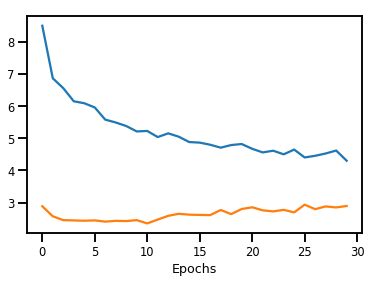

In [40]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
np.mean(hist.history['loss'])

In [41]:
d = np.loadtxt("blogdata/blogData_test-2012.03.22.00_00.csv", delimiter=',', dtype=np.float32)
Xtu = d[:,0:279]
yt = d[:,280]
Xt = (Xtu-Xmean) / (Xsd+1e-10)
d.shape, Xtu.shape, yt.shape

((206, 281), (206, 279), (206,))

In [42]:
#Glueing input and output together. Note that output is a tf.distirbution 
#model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y.mean())
model_mean = tf.keras.models.Model(inputs=inputs, outputs=p_y_nb.mean())

In [43]:
if False:
    model_mean = model

In [44]:
y_pred = model_mean.predict(Xt).flatten()

In [45]:
def check_performance(model_mean):
    files = [f for f in os.listdir('blogdata/') if f.startswith('blogData_test')]
    hits_at10 = np.zeros(len(files))
    for i,f in enumerate(files):
        d = np.loadtxt("blogdata/"+f, delimiter=',', dtype=np.float32)
        #print("{}".format(i))
        Xtu = d[:,0:279]
        yt = d[:,280]
        Xt = (Xtu-Xmean) / (Xsd+1e-10)
        d.shape, Xtu.shape, yt.shape
        y_pred = model_mean.predict(Xt).flatten()
        idx_true = np.argsort(yt)[-10:]
        idx_pred = np.argsort(y_pred)[-10:] #The 10 higest
        hits_at10[i]=len(np.intersect1d(idx_true, idx_pred))
    print(np.mean(hits_at10), np.std(hits_at10)/np.sqrt(len(files)))
    return hits_at10

check_performance(model_mean);

5.133333333333334 0.18328282132429266
